# Extracting and Tidying Up Data

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
import constants 

%matplotlib inline

## Extraction of playlist data from Spotify's API

In [11]:
OAuth = constants.OAuth
headers = {"Accept" : "application/json",
           "Content-Type" : "application/json",
           "Authorization": OAuth}
print(OAuth)

Bearer BQB2VPxGISBhboXmaoh5cAuNzcFQb4bLlGilNEwBXhpoqeT_3XyuvtbsP0ZsEPzkD1U4w2hLlAtCLrQ66BE4GQ1SckcheGvAYnpr2tRKUvSqT2e1oS044PSHaas_TLv46lOuBQbkBCeIHLscd3tlcWpSSo4i9whSYruaq6kYw63BH1y_Iok


In [12]:
def get_playlists(playlist_type, country_code, limit):
    
    '''
    Returns a dictionary of containing the given amount of playlists of the provided type from the 
    country matching the country code provided.
    '''
    
    playlists = (requests.get(url=f"https://api.spotify.com/v1/browse/categories/{playlist_type}/playlists?country={country_code}&limit={limit}",
                              headers = headers)).json()
    
    return playlists

In [13]:
def extract_playlist_ids(playlists):
    
    ''' Extract the ids of the playlists to be able to query the tracks contained in the playlist using Spotify API. '''
    
    ids = []
    playlist_info = playlists['playlists']['items']
    for i in range(len(playlist_info)):
        ids.append(playlist_info[i]['id'])
    
    return ids

In [14]:
def extract_track_info(playlist_ids):
    
    ''' Extract all of the relevant information about the tracks in a playlist, given a list a playlist ids. '''
    
    track_info = []

    for playlist in playlist_ids:
        tracks = (requests.get(url=f"https://api.spotify.com/v1/playlists/{playlist}/tracks",
                               headers = headers)).json()            
  
        fields = {"id", "name", "artists", "album", "duration_ms", "popularity"}
        for i in range(len(tracks['items'])):
            if tracks['items'][i]['track']:
                info = { key:value for key,value in tracks['items'][i]['track'].items() if key in fields}
                track_info.append(info)
            else:
                print('BARK BARK BARK >:(')
    
    return track_info

In [15]:
def get_tracks(playlist_type, country_code, limit):
    
    '''
    Returns a list containing the information for various tracks.
    playlist_type: The type of playlists where you want to query songs
    country_code: The country code of the country where you want to find the playlists
    limit: The amount of playlists you want to extract tracks from
    '''
    
    playlists = get_playlists(playlist_type, country_code, limit)
    playlist_ids = extract_playlist_ids(playlists)
    track_info = extract_track_info(playlist_ids)
    
    return track_info

In [16]:
def get_track_features(track_ids, df):
    '''
    Given an array of track ids extract the audio features of the track.
    '''
    track_features = []
    lower_bound = 0
    upper_bound = 60
    while lower_bound < len(track_ids):
        track_string = ','.join(df['id'][lower_bound:upper_bound])
        features = requests.get(url=f"https://api.spotify.com/v1/audio-features",
                                params={'ids':track_string},
                                headers=headers).json()
        lower_bound += 60
        upper_bound += 60
        if features['audio_features']:
            track_features.extend(features['audio_features'])
    return track_features

In [17]:
workout_tracks = pd.DataFrame(get_tracks('workout', 'US', 8))
workout_tracks = workout_tracks[['id', 'name', 'artists', 'album','duration_ms', 'popularity']]

display(workout_tracks.head())
print(workout_tracks.shape)

BARK BARK BARK >:(


,id,name,artists,album,duration_ms,popularity
0,2KH16WveTQWT6KOG9Rg6e2,Eye of the Tiger,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",245640,75
1,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",208400,83
2,0pqnGHJpmpxLKifKRmU6WP,Believer,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",204346,87
3,5BIMPccDwShpXq784RJlJp,Enter Sandman,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",331573,73
4,57BrRMwf9LrcmuOsyGilwr,Crawling,[{'external_urls': {'spotify': 'https://open.s...,"{'album_type': 'album', 'artists': [{'external...",208960,73


(542, 6)


In [18]:
def extract_artist_name(track_data):
    '''Given a dataframe of track_data extract the artist names from the artists column'''
    artist_names = []
    for i in range(len(track_data)):
        artist_names.append(track_data['artists'][i][0]['name'])
    
    return artist_names

In [19]:
def extract_album_name(track_data):
    '''Given a dataframe of track_data extract the album names from the album column'''
    album_names = []
    for i in range(len(track_data)):
        album_names.append(track_data['album'][i]['name'])
    
    return album_names

In [20]:
workout_tracks['artists'] = extract_artist_name(workout_tracks)
workout_tracks['album'] = extract_album_name(workout_tracks)
workout_tracks.head()

,id,name,artists,album,duration_ms,popularity
0,2KH16WveTQWT6KOG9Rg6e2,Eye of the Tiger,Survivor,Rocky IV,245640,75
1,2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,AC/DC,Highway to Hell,208400,83
2,0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,Evolve,204346,87
3,5BIMPccDwShpXq784RJlJp,Enter Sandman,Metallica,Metallica,331573,73
4,57BrRMwf9LrcmuOsyGilwr,Crawling,Linkin Park,Hybrid Theory (Bonus Edition),208960,73


## Extraction of Song Analyses

In [21]:
workout_track_features = pd.DataFrame(get_track_features(workout_tracks['id'], workout_tracks))
workout_track_features.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.13200,https://api.spotify.com/v1/audio-analysis/2KH1...,0.817,245640,0.599,2KH16WveTQWT6KOG9Rg6e2,0.000311,0,0.0873,-9.249,0,0.0328,108.873,4,https://api.spotify.com/v1/tracks/2KH16WveTQWT...,audio_features,spotify:track:2KH16WveTQWT6KOG9Rg6e2,0.548
1,0.05910,https://api.spotify.com/v1/audio-analysis/2zYz...,0.573,208400,0.913,2zYzyRzz6pRmhPzyfMEC8s,0.001730,6,0.1560,-4.793,0,0.1320,115.715,4,https://api.spotify.com/v1/tracks/2zYzyRzz6pRm...,audio_features,spotify:track:2zYzyRzz6pRmhPzyfMEC8s,0.422
2,0.06220,https://api.spotify.com/v1/audio-analysis/0pqn...,0.776,204347,0.780,0pqnGHJpmpxLKifKRmU6WP,0.000000,10,0.0810,-4.374,0,0.1280,124.949,4,https://api.spotify.com/v1/tracks/0pqnGHJpmpxL...,audio_features,spotify:track:0pqnGHJpmpxLKifKRmU6WP,0.666
3,0.00206,https://api.spotify.com/v1/audio-analysis/5BIM...,0.579,331573,0.824,5BIMPccDwShpXq784RJlJp,0.009030,6,0.0590,-8.710,0,0.0300,123.331,4,https://api.spotify.com/v1/tracks/5BIMPccDwShp...,audio_features,spotify:track:5BIMPccDwShpXq784RJlJp,0.635
4,0.04660,https://api.spotify.com/v1/audio-analysis/57Br...,0.580,208960,0.702,57BrRMwf9LrcmuOsyGilwr,0.000003,4,0.5360,-5.565,1,0.0337,105.076,4,https://api.spotify.com/v1/tracks/57BrRMwf9Lrc...,audio_features,spotify:track:57BrRMwf9LrcmuOsyGilwr,0.299


In [22]:
# Keeping only the important audio features
workout_track_features = workout_track_features[['id', 'acousticness', 'danceability','energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence']]
display(workout_track_features.head(5))
print(workout_track_features.shape)

,id,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2KH16WveTQWT6KOG9Rg6e2,0.13200,0.817,0.599,0.000311,0,0.0873,-9.249,0,0.0328,108.873,4,0.548
1,2zYzyRzz6pRmhPzyfMEC8s,0.05910,0.573,0.913,0.001730,6,0.1560,-4.793,0,0.1320,115.715,4,0.422
2,0pqnGHJpmpxLKifKRmU6WP,0.06220,0.776,0.780,0.000000,10,0.0810,-4.374,0,0.1280,124.949,4,0.666
3,5BIMPccDwShpXq784RJlJp,0.00206,0.579,0.824,0.009030,6,0.0590,-8.710,0,0.0300,123.331,4,0.635
4,57BrRMwf9LrcmuOsyGilwr,0.04660,0.580,0.702,0.000003,4,0.5360,-5.565,1,0.0337,105.076,4,0.299


(542, 13)


## Merging Data into a Consolidated Table

In [23]:
# Merge workout tracks so that all info is consolidated 
workout_tracks = pd.merge(workout_tracks, workout_track_features, on="id", how="inner").set_index('id')
workout_tracks.head()

,name,artists,album,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,,,
2KH16WveTQWT6KOG9Rg6e2,Eye of the Tiger,Survivor,Rocky IV,245640,75,0.1320,0.817,0.599,0.000311,0,0.0873,-9.249,0,0.0328,108.873,4,0.548
2zYzyRzz6pRmhPzyfMEC8s,Highway to Hell,AC/DC,Highway to Hell,208400,83,0.0591,0.573,0.913,0.001730,6,0.1560,-4.793,0,0.1320,115.715,4,0.422
0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,Evolve,204346,87,0.0622,0.776,0.780,0.000000,10,0.0810,-4.374,0,0.1280,124.949,4,0.666
0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,Evolve,204346,87,0.0622,0.776,0.780,0.000000,10,0.0810,-4.374,0,0.1280,124.949,4,0.666
0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,Evolve,204346,87,0.0622,0.776,0.780,0.000000,10,0.0810,-4.374,0,0.1280,124.949,4,0.666


In [24]:
print("Number of unique tracks:", workout_tracks.name.nunique())
print("Number of tracks:", len(workout_tracks))

Number of unique tracks: 501
Number of tracks: 580


### At this point we've extracted all of our necessary information. Note that there are repeated tracks, which makes sense since popular songs tend to be present in many different playlists.

In [25]:
# Out of curiosity, going to check the duplicate songs
workout_tracks.loc[workout_tracks.duplicated(subset='name')]['name'].unique()

array(['Believer', "'Till I Collapse", 'Something Just Like This',
       "If I Can't Have You", 'Shape of You', 'Happier', '24K Magic',
       'Rescue Me', 'Who Do You Love', 'Never Really Over', 'The Middle',
       'More Than You Know', 'POWER', 'Act Up', 'Stronger',
       'Numb / Encore', "X Gon' Give It To Ya", 'Jumpman',
       'CAN\'T STOP THE FEELING! (Original Song from DreamWorks Animation\'s "TROLLS")',
       'ME! (feat. Brendon Urie of Panic! At The Disco)', 'Thunder',
       'Sucker', 'Cake By The Ocean', 'Natural',
       "I Don't Care (with Justin Bieber)", 'You Need To Calm Down',
       'Sorry', 'Youngblood', '2002', 'Despacito - Remix', 'Attention',
       'Stitches', 'Gold Digger', 'The Next Episode',
       'Bandz A Make Her Dance'], dtype=object)

In [26]:
workout_tracks.drop_duplicates(inplace=True)

In [27]:
print("Number of unique tracks:", workout_tracks.name.nunique())
print("Number of tracks:", len(workout_tracks))

Number of unique tracks: 501
Number of tracks: 526


### After dropping duplicates there are still tracks with duplicate names. Before dropping them entirely, it'd be wise to investigate why they weren't dropped

In [28]:
workout_tracks[workout_tracks.duplicated(subset='name', keep=False)].sort_values(by='name').head(10)

,name,artists,album,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
id,,,,,,,,,,,,,,,,,
4Pbg79cTBu4vgSphoyNq3j,2002,Anne-Marie,2002,186986,77,0.03720,0.697,0.683,0.000000,1,0.1370,-2.881,0,0.1170,96.133,4,0.603
2BgEsaKNfHUdlh97KmvFyo,2002,Anne-Marie,Speak Your Mind (Deluxe),186986,83,0.03720,0.697,0.683,0.000000,1,0.1370,-2.881,0,0.1170,96.133,4,0.603
4iLqG9SeJSnt0cSPICSjxv,Attention,Charlie Puth,Attention,211475,25,0.09690,0.774,0.626,0.000031,3,0.0848,-4.432,0,0.0432,100.041,4,0.777
5cF0dROlMOK5uNZtivgu50,Attention,Charlie Puth,Voicenotes,208786,82,0.10900,0.775,0.613,0.000023,3,0.1340,-4.586,0,0.0542,100.066,4,0.797
7EZPH9Px3gXlxD5KJDwtwc,Bandz A Make Her Dance,Juicy J,Stay Trippy,278826,64,0.00212,0.871,0.743,0.000000,2,0.1410,-5.442,1,0.2770,130.977,4,0.576
0CpLNO56aPUBQ8roB4ufSa,Bandz A Make Her Dance,Juicy J,Bandz A Make Her Dance (Explicit Version),280053,1,0.00101,0.880,0.674,0.000000,2,0.2800,-7.857,1,0.3330,130.972,4,0.584
05KfyCEE6otdlT1pp2VIjP,Believer,Imagine Dragons,Believer,203782,15,0.04170,0.772,0.775,0.000000,10,0.2260,-4.388,0,0.1120,124.978,4,0.748
0pqnGHJpmpxLKifKRmU6WP,Believer,Imagine Dragons,Evolve,204346,87,0.06220,0.776,0.780,0.000000,10,0.0810,-4.374,0,0.1280,124.949,4,0.666
1WkMMavIMc4JZ8cfMmxHkI,CAN'T STOP THE FEELING! (Original Song from Dr...,Justin Timberlake,TROLLS (Original Motion Picture Soundtrack),237546,74,0.01060,0.669,0.832,0.000000,0,0.0968,-5.720,1,0.0682,113.035,4,0.700


### Reasons for Duplicates:
1. Same Song Different Artist
2. Same Song Same Artist Different Album
3. Same Everything, but Different Analysis  

#### Handle the second case and third case by dropping the less popular version.

In [29]:
workout_tracks = workout_tracks.sort_values(by=['name', 'popularity'], ascending = False)
workout_tracks.drop_duplicates(subset=['name', 'artists'], inplace=True)

In [30]:
# If this passes I can safely assume all duplicates have been removed
assert not any(workout_tracks.duplicated(subset=['name', 'artists'], keep=False))

### All duplicate records have been removed. Now we need to check data types and null values.

#### Checking for nulls

In [31]:
# If assertion error, then a column in the data contains a null value
assert not any(workout_tracks.isna().any())

#### Checking and adjusting dtypes

In [32]:
workout_tracks.dtypes

name                 object
artists              object
album                object
duration_ms           int64
popularity            int64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
time_signature        int64
valence             float64
dtype: object

In [33]:
print(workout_tracks['time_signature'].value_counts())
print(workout_tracks['key'].value_counts())
print(workout_tracks['mode'].value_counts())

4    486
5     13
3      4
Name: time_signature, dtype: int64
1     98
0     49
2     47
7     41
5     41
11    40
9     36
8     36
6     35
4     32
10    31
3     17
Name: key, dtype: int64
1    297
0    206
Name: mode, dtype: int64


In [34]:
# The above 3 columns can be better represented as categories
workout_tracks[['time_signature', 'key', 'mode']] = workout_tracks[['time_signature', 'key', 'mode']].astype('category')

In [35]:
workout_tracks.dtypes

name                  object
artists               object
album                 object
duration_ms            int64
popularity             int64
acousticness         float64
danceability         float64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
speechiness          float64
tempo                float64
time_signature      category
valence              float64
dtype: object

### Exploring Outliers and Distribution of Data

In [36]:
workout_tracks.describe()

,duration_ms,popularity,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000,503.000000
mean,208430.437376,59.367793,0.099660,0.698183,0.740443,0.050342,0.213451,-5.340276,0.164363,125.468799,0.487820
std,42425.011162,20.248996,0.145522,0.139644,0.149437,0.169497,0.173535,2.168794,0.137291,26.452582,0.224423
min,94245.000000,0.000000,0.000079,0.258000,0.235000,0.000000,0.028500,-15.545000,0.027500,70.023000,0.059100
25%,180918.500000,52.000000,0.008385,0.601000,0.629000,0.000000,0.094450,-6.469500,0.051800,104.506500,0.307000
50%,204400.000000,62.000000,0.037000,0.701000,0.753000,0.000000,0.145000,-5.041000,0.108000,126.060000,0.490000
75%,230446.500000,73.000000,0.137000,0.798000,0.859500,0.000236,0.299500,-4.113000,0.262500,144.221000,0.653000
max,369573.000000,100.000000,0.860000,0.980000,0.995000,0.971000,0.915000,0.101000,0.775000,212.080000,0.969000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024E77CB0390>,
      dtype=object)

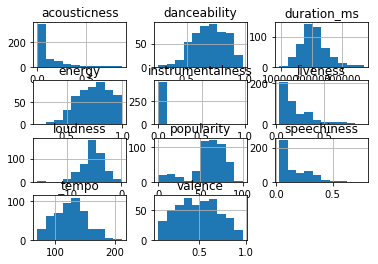

In [37]:
workout_tracks.hist()